Keras CNN으로 이미지 분할하기

1. 패키지 수입

In [ ]:
# 1번 블럭

import numpy as np
import os
from PIL import Image #python image library(PIL)
from PIL.ImageOps import autocontrast
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img , array_to_img
from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Input, MaxPooling2D, Add
from keras.layers import Convolution2DTranspose, UpSampling2D

In [ ]:
# 2번 블럭

#하이퍼 파라미터
MY_EPOCH = 50
MY_BATCH = 32
MY_RES = 160

#데이터 처리 모드
DATA_MODE = 0

#CNN 학습 모드
TRAIN_MODE = 0

#데이터 경로
MY_PATH = '/content/drive/MyDrive/dataset/pet'

2. 데이터 처리

In [ ]:
# 3번 블럭

#입력 이미지 경로 처리
input_dir = os.path.join(MY_PATH, 'images')
print(input_dir)
img_path = sorted([
                   os.path.join(input_dir,fname)
                   for fname in os.listdir(input_dir)
])
img_tot = len(img_path)
print("입력 이미지 갯수:",len(img_path))
print("샘플 경로:" ,img_path[0])

/content/drive/MyDrive/dataset/pet/images
입력 이미지 갯수: 1190
샘플 경로: /content/drive/MyDrive/dataset/pet/images/Ragdoll_1.jpg


In [ ]:
# 4번 블럭

#출력 이미지 경로
target_dir = os.path.join(MY_PATH , 'trimaps')
target_path = sorted([
                      os.path.join(target_dir, fname)
                      for fname in os.listdir(target_dir)
])

print("출력 이미지 갯수: ",len(target_path))
print("샘플 이미지 경로: ", target_path[0])

출력 이미지 갯수:  1190
샘플 이미지 경로:  /content/drive/MyDrive/dataset/pet/trimaps/Ragdoll_1.png


In [ ]:
# 5번 블럭

#출력 이미지 정보 출력
which = 28
img = load_img(target_path[which])
print(img)
img = autocontrast(img)

#PIL 이미지를 numpy 행렬로 전환
np.set_printoptions(threshold=np.inf)
tmp = np.unique(np.asarray(img))
print(tmp)

#trimaps 룰
# 1: 대상 -> 0 (검정)
# 2: 배경 -> 127 (회색)
# 3: 윤곽 -> 255 (흰색)

<PIL.Image.Image image mode=RGB size=291x500 at 0x7FB1E11430D0>
[  0 127 255]


(-0.5, 290.5, 499.5, -0.5)

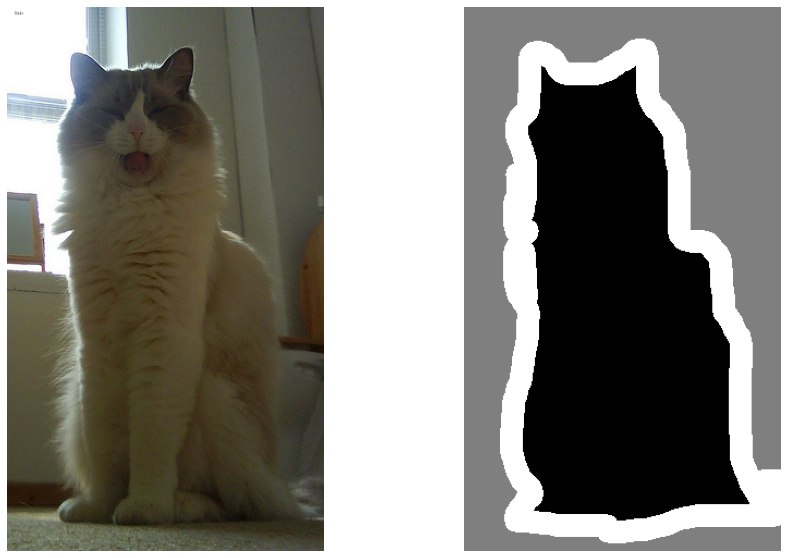

In [ ]:
# 6번 블럭

#샘플 이미지 출력
fig, spot = plt.subplots(1,2, figsize=(15,10))
spot[0].imshow(Image.open(img_path[which]))
spot[0].axis('off')

#spot[1].imshow(Image.open(target_path[which]))
spot[1].imshow(autocontrast(load_img(target_path[which])))
spot[1].axis('off')

In [ ]:
# 7번 블럭

# 이미지 화소 스케일링
# 20분 소요
if DATA_MODE:
  print('데이터 스케일링 시작')
  begin = time()

  # 4차원
  # 3은 RGB channel 수
  X_data = np.zeros((img_tot, MY_RES , MY_RES, 3))
  for j,path in enumerate(img_path):
    #이미지 크기 통일 하기
    # channel은 그대로 3으로 유지
    #tmp = load_img(path)
    img = load_img(path , target_size=(MY_RES,MY_RES))
    X_data[j] = img

  end = time()
  print('입력 데이터 처리 시간: {:.2f}초'.format(end-begin))
  print('입력 데이터 모양: ', X_data.shape)  # 이미지수,화소수,화소수,채널

In [ ]:
# 8번 블럭

# 출력 이미지 (= 윤곽선 결과) 처리
if DATA_MODE:
  print('출력 이미지 처리 시작')
  begin = time()

  Y_data = np.zeros((img_tot, MY_RES, MY_RES,1))
  for j, path in enumerate(target_path):
    map = load_img(path, target_size=(MY_RES, MY_RES), color_mode='grayscale')
    
    # 채널 정보 추가
    Y_data[j] = np.expand_dims(map, axis=2)
    #trimap 데이터범위를 [1,2,3]에서 [0,1,2]로 전환
    Y_data[j] -= 1
  end = time()
  print('출력 데이터 처리 시간: {:.2f}초'.format(end-begin))
  print('출력 데이터 모양: ', Y_data.shape)   

In [ ]:
# 9번 블럭

# numpy 데이터 저장
if DATA_MODE:
  with open('arrays.npy', 'wb') as f:
    np.save(f, X_data)
    np.save(f, Y_data)

  print('numpy 데이터 파일 완성')

else:
  with open('/content/drive/MyDrive/dataset/arrays.npy', 'rb') as f:
    X_data = np.load(f)
    Y_data = np.load(f)

(-0.5, 159.5, 159.5, -0.5)

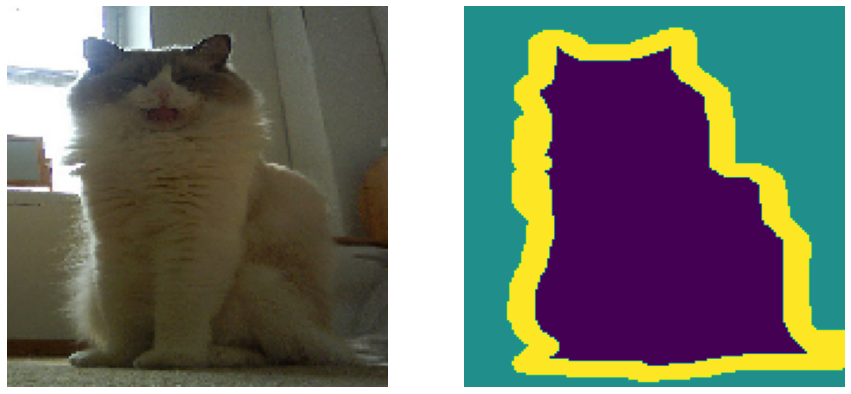

In [ ]:
# 10번 블럭

# 160,160 scaling 후 이미지 출력
fig , spot = plt.subplots(1,2, figsize = (15,10))

# 컬러 이미지 출력
img = array_to_img(X_data[which])
spot[0].imshow(img)
spot[0].axis('off')

# 윤곽 데이터 출력
img = array_to_img(Y_data[which])
spot[1].imshow(img)
spot[1].axis('off')

In [ ]:
# 11번 블럭

# 데이터 4분할
X_train , X_test, Y_train, Y_test = train_test_split(X_data,
                                                     Y_data,
                                                     test_size = 0.2)
# 최종 데이터 모양 확인
print('학습용 입력 데이터 모양: ',X_train.shape)
print('학습용 출력 데이터 모양: ',Y_train.shape)
print('평가용 입력 데이터 모양: ',X_test.shape)
print('평가용 출력 데이터 모양: ',Y_test.shape)

학습용 입력 데이터 모양:  (952, 160, 160, 3)
학습용 출력 데이터 모양:  (952, 160, 160, 1)
평가용 입력 데이터 모양:  (238, 160, 160, 3)
평가용 출력 데이터 모양:  (238, 160, 160, 1)


3. 인공 신경망 구현

In [ ]:
# 12번 블럭

#Unet의 전반부 인코더 구현
def build_enc():
  # 입력층 구현
  inputs = Input(shape = (MY_RES, MY_RES, 3))

  # 합성곱 블럭 0번
  x = Conv2D(filters=32,
             kernel_size=3,
             strides=2,
             padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # 잔차 연결 준비
  jump = x

  # 합성곱 블럭 1,2,3 구현
  for filters in [64, 128, 256]:
    # 첫번째 합성곱
    x = Activation('relu')(x)
    x = SeparableConv2D(filters,
                        kernel_size = 3,
                        padding = 'same')(x)
    x = BatchNormalization()(x)

    # 두번째 합성곱
    x = Activation('relu')(x)
    x = SeparableConv2D(filters,
                        kernel_size = 3,
                        padding = 'same')(x)
    x = BatchNormalization()(x)

    # 풀링
    x = MaxPooling2D(pool_size=3,
                     strides=2,
                     padding='same')(x)

    # 잔차 연결
    residual = Conv2D(filters,
                      kernel_size=1,
                      strides=2,
                      padding='same')(jump)
    
    # 두 갈래 묶어주기
    x = Add()([x, residual])
    jump = x
    
  #입력과 출력값 return
  return inputs, x

In [ ]:
# 13번 블럭

def build_dec(inputs, x):
  # 잔차 연결 준비
  jump = x

  # 합성곱 블럭 4번 반복
  for filters in [256, 128, 64, 32]:
    # 첫번째 합성곱
    x = Activation('relu')(x)
    x = Convolution2DTranspose(filters,
                               kernel_size=3,
                               padding ='same')(x)
    x = BatchNormalization()(x)

    # 두번째 합성곱
    x = Activation('relu')(x)
    x = Convolution2DTranspose(filters,
                               kernel_size=3,
                               padding ='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=2)(x)

    # 잔차 블럭
    residual = UpSampling2D(size=2)(jump)
    residual = Conv2D(filters,
                      kernel_size=1,
                      padding='same')(residual)

    # 더하기
    x = Add()([x,residual])
    jump = x
  
  # 최종 출력층
  outputs = Conv2D(filters=3,
                   kernel_size=3,
                   activation='softmax',
                   padding='same')(x)

  # Unet 출력
  model = Model(inputs, outputs)
 
  return model


In [ ]:
# 14번 블럭

inputs, link = build_enc()
model = build_dec(inputs, link)

print('Unet 요약')
model.summary()

Unet 요약
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________

4. 인공신경망 학습

In [ ]:
# 15번 블럭
# Unet 학습 시작

if TRAIN_MODE:
  model.compile(optimizer='rmsprop',
                loss = 'sparse_categorical_crossentropy')
  
  print('학습 시작')
  begin = time()

  model.fit(X_train, Y_train, MY_BATCH, MY_EPOCH , verbose=1)
  end = time()

  print('총 학습 시간:{:.2f}'.format(end-begin))
  model.save_weights('segment.h5')
else:
  model.load_weights('/content/drive/MyDrive/dataset/segment.h5')

5. 인공 신경망 활용

8/8 [==============================] - 34s 131ms/step


(-0.5, 159.5, 159.5, -0.5)

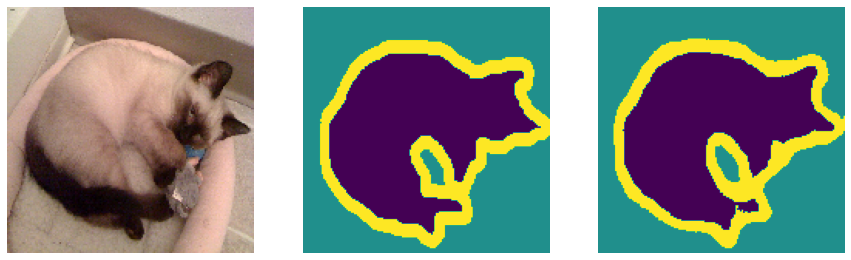

In [ ]:
# 16번 블럭

fig, spot = plt.subplots(1, 3, figsize=(15,8))

#컬러 이미지 출력
img = array_to_img(X_test[which])
spot[0].imshow(img)
spot[0].axis('off')

# 정답 출력
img = array_to_img(Y_test[which])
spot[1].imshow(img)
spot[1].axis('off')

# 기계 추측
pred = model.predict(X_test, verbose=1)

# 확률 출력
# print(pred[which])

print(pred[which].shape)
mask = np.argmax(pred[which], axis= 2)
# print(mask)
mask = np.expand_dims(mask, axis=2)
print(mask.shape)

img = array_to_img(mask)
spot[2].imshow(img)
spot[2].axis('off')